# Bank Customer Segmentation and Personalization
To effectively segment banking customers for targeted marketing and personalized services, we'll begin with Data Exploration and Preprocessing.

## Data Exploration & Preprocessing
### Examine the Data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from datetime import datetime

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Load the dataset
df = pd.read_csv('bank_transactions.csv')

# Check the shape of the dataset (rows, columns)
print("Dataset shape (rows, columns):\n", df.shape)

# Get dataset information (column names, non-null counts, data types)
print("Dataset Info:\n")
df.info()

# Display first 5 rows
print("\nFirst 5 rows:\n", df.head())

Dataset shape (rows, columns):
 (1048567, 9)
Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB

First 5 rows:
   TransactionID CustomerID CustomerDOB CustGender CustLocation  \
0            T1   C5841053     10/1/94          F   JAMSHEDPUR   
1

Using Pandas and NumPy, we can compute summary statistics to understand the distributions of these features.

In [2]:
# Summary statistics for numerical columns
print("\nSummary Statistics:\n", df.describe())


Summary Statistics:
        CustAccountBalance  TransactionTime  TransactionAmount (INR)
count        1.046198e+06     1.048567e+06             1.048567e+06
mean         1.154035e+05     1.570875e+05             1.574335e+03
std          8.464854e+05     5.126185e+04             6.574743e+03
min          0.000000e+00     0.000000e+00             0.000000e+00
25%          4.721760e+03     1.240300e+05             1.610000e+02
50%          1.679218e+04     1.642260e+05             4.590300e+02
75%          5.765736e+04     2.000100e+05             1.200000e+03
max          1.150355e+08     2.359590e+05             1.560035e+06


### Data Cleaning
#### Checking missing values
Identify missing values.

In [3]:
# Total missing values per column
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64


#### Imputation Strategy
- `CustomerDOB`: Convert to age, then impute missing values with the median age.
- `CustGender`: Fill missing values with the most common gender.
- `CustLocation`: Fill with "Unknown" or mode.
- `CustAccountBalance`: Fill missing values with the median.

In [4]:
# Convert 'CustomerDOB' to datetime
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'])

# Calculate age
df['Age'] = (pd.to_datetime('today') - df['CustomerDOB']).dt.days // 365

# Drop the original 'CustomerDOB' column
df.drop(columns=['CustomerDOB'], inplace=True)

# Fill missing age values with median age
df['Age'].fillna(df['Age'].median(), inplace=True)

# Fill missing categorical values with mode
df['CustGender'].fillna(df['CustGender'].mode()[0], inplace=True)
df['CustLocation'].fillna('Unknown', inplace=True)

# Fill missing numerical values with median
df['CustAccountBalance'].fillna(df['CustAccountBalance'].median(), inplace=True)

C:\Users\sghas\AppData\Local\Temp\ipykernel_13392\1988404672.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'])
C:\Users\sghas\AppData\Local\Temp\ipykernel_13392\1988404672.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
C:\Users\sghas\AppData\Local\Temp\ipykernel_13392\1988404672

The `fillna()` function in Pandas is used to fill missing values in a DataFrame.

In [5]:
# Total missing values per column
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 TransactionID              0
CustomerID                 0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
Age                        0
dtype: int64


### Feature Engineering
#### Extracting Features from Date & Time
- Convert `TransactionDate` to recency (days since last transaction).
- Convert `TransactionTime` to hour of transaction for behavior analysis.

In [6]:
# Convert TransactionDate to datetime
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# Calculate recency (days since last transaction)
df['DaysSinceLastTransaction'] = (datetime.now() - df['TransactionDate']).dt.days

# Convert TransactionTime (seconds) to hours
df['TransactionHour'] = df['TransactionTime'] // 3600

C:\Users\sghas\AppData\Local\Temp\ipykernel_13392\3698491901.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])


#### Creating RFM Features (Recency, Frequency, Monetary)
- Recency: Days since last transaction.
- Frequency: Number of transactions per customer.
- Monetary: Total transaction amount per customer.

In [7]:
# Group by CustomerID
rfm = df.groupby('CustomerID').agg({
    'DaysSinceLastTransaction': 'min',  # Recency (most recent transaction)
    'TransactionID': 'count',  # Frequency (number of transactions)
    'TransactionAmount (INR)': 'sum'  # Monetary (total spending)
}).reset_index()

# Rename columns
rfm.rename(columns={'DaysSinceLastTransaction': 'Recency', 'TransactionID': 'Frequency', 'TransactionAmount (INR)': 'Monetary'}, inplace=True)

# Merge back with original dataset
df = df.merge(rfm, on='CustomerID', how='left')

##### RFM Usage
- Recency: Customers who have recently transacted are likely to be more loyal.

- Frequency: Customers who have transacted more are more valuable.

- Monetary: Customers who have spent more are more profitable.

Using these features, customers can be divided into different groups and personalized marketing strategies can be designed for each group.

### Data Visualization for Customer Trends
Before clustering, we’ll generate visualizations to analyze key customer behavior trends. This includes:
- Demographic Distribution (Age, Gender)
- Transaction Behavior (Frequency, Recency, Monetary)
- Account Balances & Spending Patterns
- Correlation Heatmap for Feature Selection

#### Distribution of Customer Age
Helps understand the dominant customer demographics.

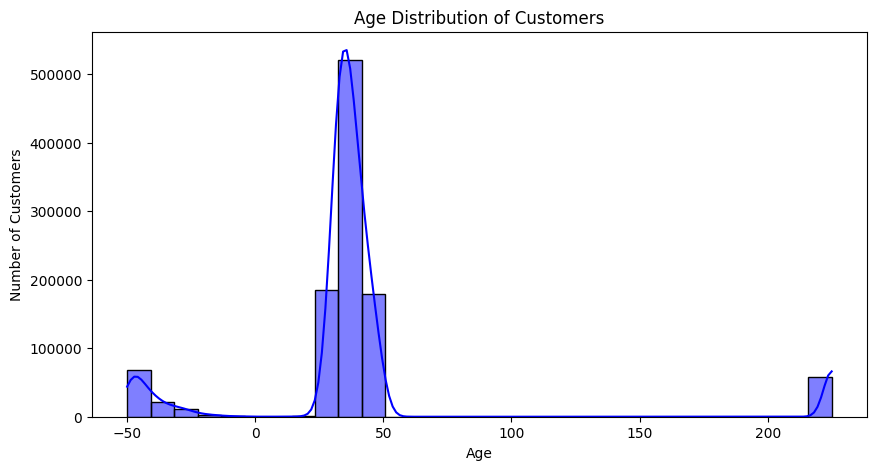

In [8]:
# Plot age distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['Age'], bins=30, kde=True, color='blue')
plt.title('Age Distribution of Customers')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.show()

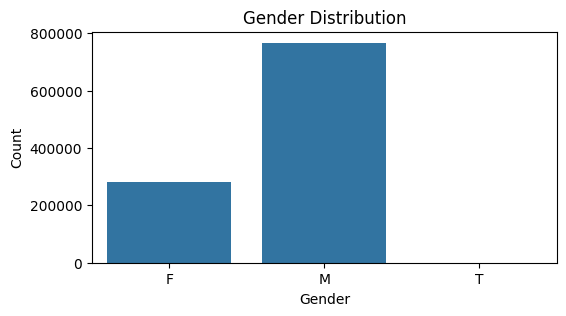

In [9]:
# Gender bar plot
plt.figure(figsize=(6, 3))
sns.countplot(x='CustGender', data=df)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

#### Recency, Frequency, and Monetary (RFM) Analysis

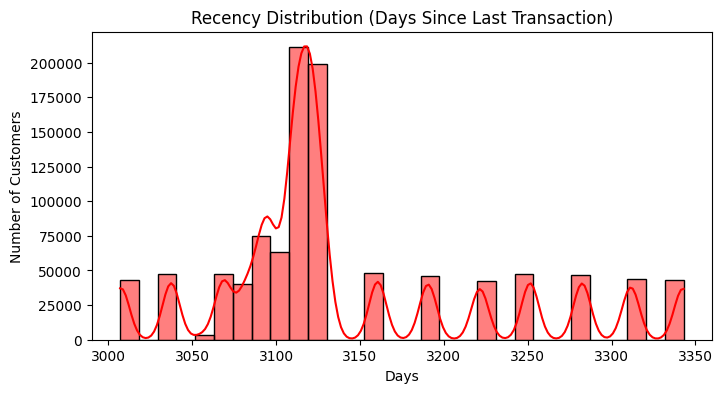

In [10]:
plt.figure(figsize=(8, 4))
sns.histplot(df['DaysSinceLastTransaction'], bins=30, kde=True, color='red')
plt.title('Recency Distribution (Days Since Last Transaction)')
plt.xlabel('Days')
plt.ylabel('Number of Customers')
plt.show()

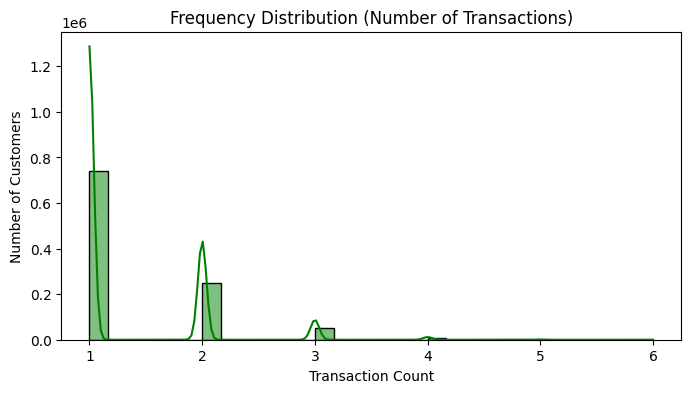

In [11]:
plt.figure(figsize=(8, 4))
sns.histplot(df['Frequency'], bins=30, kde=True, color='green')
plt.title('Frequency Distribution (Number of Transactions)')
plt.xlabel('Transaction Count')
plt.ylabel('Number of Customers')
plt.show()

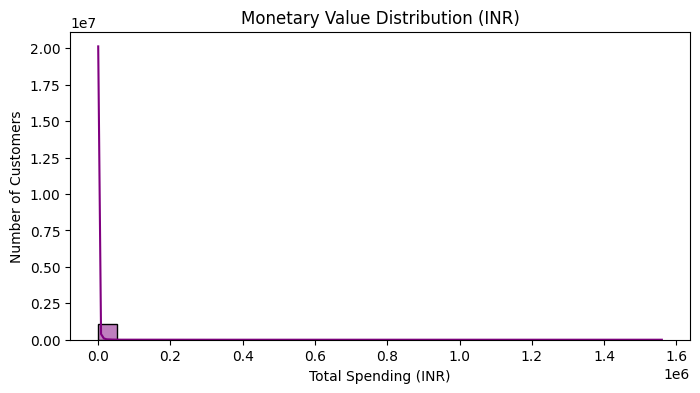

In [12]:
plt.figure(figsize=(8, 4))
sns.histplot(df['Monetary'], bins=30, kde=True, color='purple')
plt.title('Monetary Value Distribution (INR)')
plt.xlabel('Total Spending (INR)')
plt.ylabel('Number of Customers')
plt.show()

#### Account Balance vs. Spending Patterns
Helps identify high-value customers.

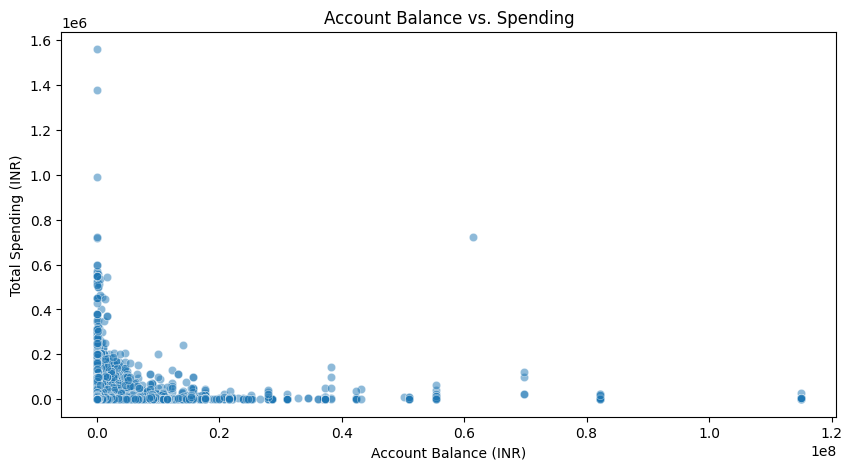

In [13]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['CustAccountBalance'], y=df['Monetary'], alpha=0.5)
plt.title('Account Balance vs. Spending')
plt.xlabel('Account Balance (INR)')
plt.ylabel('Total Spending (INR)')
plt.show()

#### Encoding & Normalization
- One-Hot Encode `CustGender` and `CustLocation`.
- Scale Numerical Features (Account Balance, RFM Metrics, Age).

In [14]:
# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['CustGender', 'CustLocation'], drop_first=True)

# Normalize numerical features
scaler = StandardScaler()
num_cols = ['CustAccountBalance', 'Age', 'DaysSinceLastTransaction', 'Frequency', 'Monetary']
df[num_cols] = scaler.fit_transform(df[num_cols])

## Model Development & Evaluation
We will now develop a customer segmentation model using clustering techniques and evaluate its performance.
### Applying Clustering Algorithms
#### K-Means Clustering
- Efficient and scalable for large datasets.
- Forms compact, well-separated clusters.
#### Choosing the Optimal K (Number of Clusters)
- Use Elbow Method to find the best value of K.
- Compute inertia (sum of squared distances within clusters) for different values of K.
- The elbow point indicates the best K (number of clusters) where adding more clusters doesn't significantly reduce variance.

C:\myProjects\Customer-Segmentation-Personalization\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\myProjects\Customer-Segmentation-Personalization\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\sghas\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\sghas\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", lin

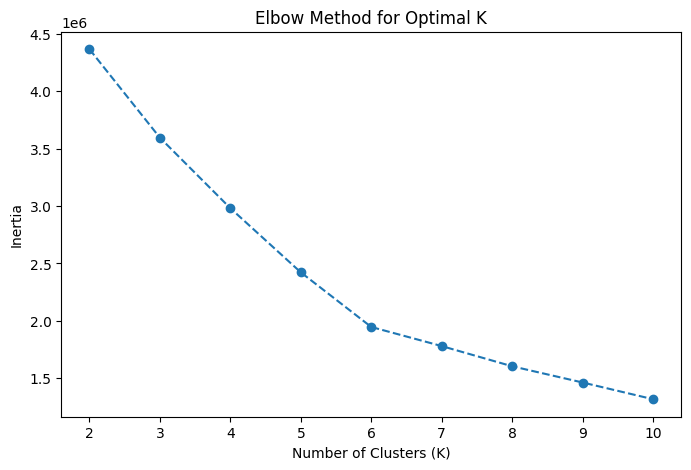

In [15]:
# Select relevant features for clustering
features = ['CustAccountBalance', 'Age', 'DaysSinceLastTransaction', 'Frequency', 'Monetary']

# Extract values for clustering
X = df[features].values

# Determine the optimal number of clusters using the Elbow Method
inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

- The inertia (sum of squared distances within clusters) decreases as `K` increases.
- The rate of decrease slows down significantly around K = 5 or 6, forming an "elbow."
- Before K = 5, inertia drops sharply, meaning adding clusters significantly reduces within-cluster variance.
- After K = 6, inertia decreases at a much slower rate, indicating diminishing returns.
##### Conclusion:
- The optimal K is likely between 5 and 6.
- Choosing K=6 might be preferable as it balances segmentation quality and computational efficiency.
- To confirm, we can check the Silhouette Score for K=5 and K=6 to see which one provides better-defined clusters. At the moment we take K=5.

### Fit K-Means with the Optimal K
After identifying the best K, we train the final model.

In [16]:
# Train the K-Means model with K=6
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)
df['Cluster'] = cluster_labels  # Assign clusters to the original dataframe

### Evaluate the Clustering Performance
Compute the Silhouette Score to measure cluster quality.

In [ ]:
sil_score = silhouette_score(X, cluster_labels)
print(f'Silhouette Score for K=5: {sil_score:.4f}')

### Visualize the Clusters
Use Principal Component Analysis (PCA) to reduce dimensions for visualization.

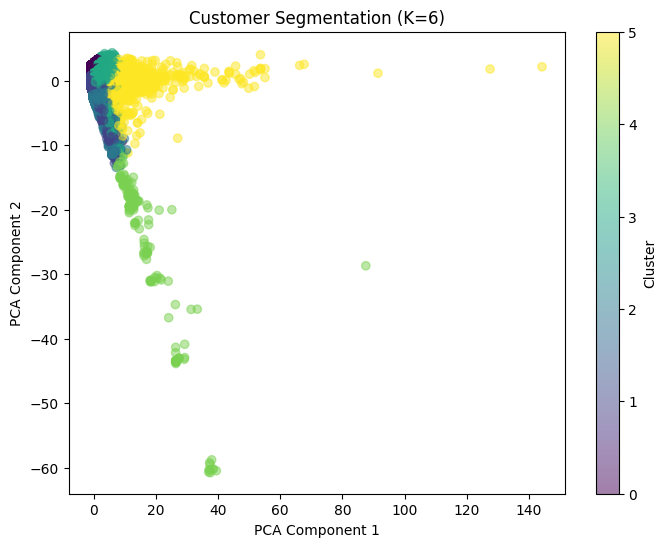

In [19]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.colorbar(label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Segmentation (K=6)')
plt.show()

This PCA visualization represents customer segmentation with K=6 clusters. Here’s an analysis of the segmentation:

#### Key Observations:
##### Cluster Separation
- The clusters seem to be overlapping in some areas, which might indicate that some segments are not clearly distinguished.
- The yellow cluster is spread widely, suggesting it may contain diverse customers.
- The green cluster appears concentrated towards the bottom, indicating a unique group with distinct characteristics.
##### Potential Issues:
- Some points are far from the main clusters, possibly outliers or highly different customer behaviors.
- If some clusters seem too small or too similar, we might need to revisit feature selection or scaling.

Compute summary statistics for each cluster:

In [21]:
df_numeric = df.select_dtypes(include=['number'])  # Select only numeric columns
df_numeric['Cluster'] = df['Cluster']  # Add cluster labels back
cluster_summary = df_numeric.groupby('Cluster').mean()  # Compute mean for each cluster
print(cluster_summary)

         CustAccountBalance  TransactionTime  TransactionAmount (INR)  \
Cluster                                                                 
0                 -0.027656    157816.696280              1281.878149   
1                 -0.018995    157344.519846              1231.972769   
2                  0.161438    151648.410535              2429.238184   
3                 -0.020088    157220.114186              1247.262119   
4                 56.869332    141842.150289             12386.053815   
5                  0.352508    156328.357770             57625.678711   

              Age  DaysSinceLastTransaction  TransactionHour      Recency  \
Cluster                                                                     
0       -0.201616                  1.718464        43.343984  3249.876088   
1       -0.213683                 -0.453537        43.213082  3105.799004   
2        3.660566                 -0.031896        41.630942  3127.521766   
3       -0.210238             

####  Save the Trained Model

In [27]:
# Save trained K-Means model
joblib.dump(kmeans, 'customer_segmentation_model.pkl')

['customer_segmentation_model.pkl']